<a href="https://colab.research.google.com/github/avinash-tiwary/MCMC/blob/main/Supernova_MCMC_2103121006.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Importing Data of z, mu and covariance matrix 
jla_mub_0 = "https://raw.githubusercontent.com/avinash-tiwary/MCMC/main/jla_mub_0.csv"
jla_mub_covmatrix = 'https://raw.githubusercontent.com/avinash-tiwary/MCMC/main/jla_mub_covmatrix.csv'

data_1, data_2= pd.read_csv(jla_mub_0), pd.read_csv(jla_mub_covmatrix)
z, mu, data = data_1.z, data_1.mu, data_2.data

#Number of supernova observed
Nbins = 31 

#Coverting given data into covariance matrix
cov_matrix = np.zeros([Nbins,Nbins])
for i in range(Nbins):
    for j in range(Nbins):
        cov_matrix[i,j] = data[i*Nbins + j]

# Taking inverse of covarience matrix
Inv_cov_matrix = np.linalg.inv(cov_matrix)

#All the required functions are defined here
#-----------------------------------------------------------------------------------------
# Defining eta to use in DL
def eta(a, Omega_m):
    s = ((1-Omega_m)/Omega_m)**(1/3)
    return 2*((s**3 + 1)**0.5)*((1/a**4) - (0.1540*s/a**3) + (0.4304*(s**2)/a**2) + 
                                        (0.19097*(s**3)/a) + 0.066941*s**4)**(-1/8)  

#Luminosity distance for Flat Universe (At redshift z for given Omega_m and h)             
def DL(z, Omega_m, h):
    return (3000/h)*(1.0+z)*(eta(1.0,Omega_m) -eta(1.0/(1.0+z), Omega_m))

def mu_theory(z, Omega_m, h):
    return 25.0 + 5.0*np.log10(DL(z,Omega_m, h))

def mu_diff(Omega_m, h):
    MU = np.zeros(Nbins)
    for i in range(Nbins):
        MU[i] = mu[i] - mu_theory(z[i], Omega_m, h)
    return MU

# Defining log of likelihood (Assuming gaussian errors)
def likelihood(Omega_m, h):
    if(Omega_m > 0 and h>0 and Omega_m < 1) and h <1:
        log_L = -0.5*np.dot(mu_diff(Omega_m, h), np.dot(Inv_cov_matrix,mu_diff(Omega_m, h)))
    else:
        log_L = -1*np.exp(100)
    return log_L
#---------------------------------------------------------------------------------------------

#Number of sampling steps
n_samp = 10000

# Generating first random value of h and Omega_m to start the Algorithm
h_accept = [np.random.uniform(0,1)]
omega_m_accept = [np.random.uniform(0,1)]
prob = np.array([0])


# Metroplis-Hastings algorithm:
for i in range(n_samp):

    #Generating random values of h and Omega_m in range (0,1) with Gaussian proposal distribution
    h_random       = np.random.normal(h_accept[0], 0.01)
    omega_m_random = np.random.normal(omega_m_accept[0], 0.01)

    #Calulating log of likelihood of these randomly generated 
    new_log_L = likelihood(omega_m_random, h_random)

    '''
    calulating acceptance probability and taking minimum of 1 and ratio of likelihood of new omega_m and h to
    previous accepted omega_m and h. If the ratio of likelihood is increased then it is accepted without condition.
    But if the likelihood goes down in next step then it would be accepted with uniform probability.
    '''
    acc_prob = min(np.exp(new_log_L - likelihood(omega_m_accept[0], h_accept[0])), 1)

    if np.random.uniform(0, 1) < acc_prob:
        h_accept       = np.append(h_random, h_accept)
        omega_m_accept = np.append(omega_m_random, omega_m_accept)
        prob           = np.append(new_log_L, prob)
        

#Excluding 10% of Burn In data
burnin = int(n_samp/10)

print(f'''
Average of Omega_m = {np.mean(omega_m_accept[:burnin])}
Std of Omega_m     = {np.std(omega_m_accept[:burnin])}
Average of h       = {np.mean(h_accept[:burnin])}
Std of h           = {np.std(h_accept[:burnin])}

Covariance of Omega_m and h is:
{np.cov(omega_m_accept[:burnin], h_accept[:burnin])}
    ''')


Average of Omega_m = 0.2962086178327538
Std of Omega_m     = 0.03132288235200254
Average of h       = 0.7031601846914277
Std of h           = 0.0074504846508284435

Covariance of Omega_m and h is:
[[ 9.82105064e-04 -1.47399126e-04]
 [-1.47399126e-04  5.55652868e-05]]
    


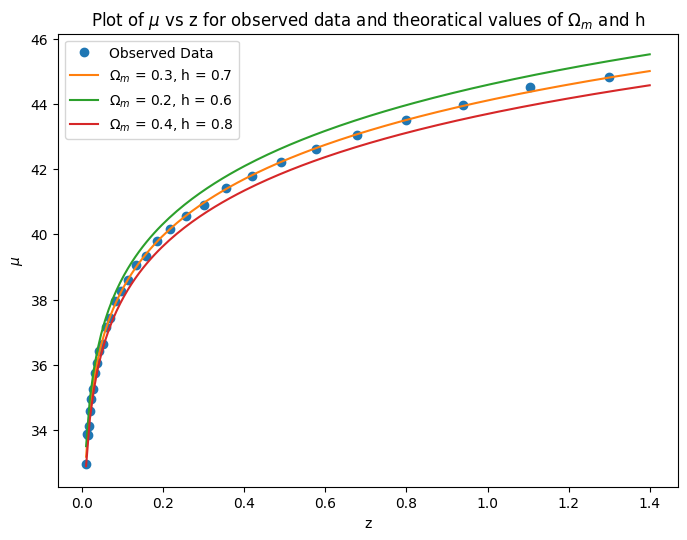

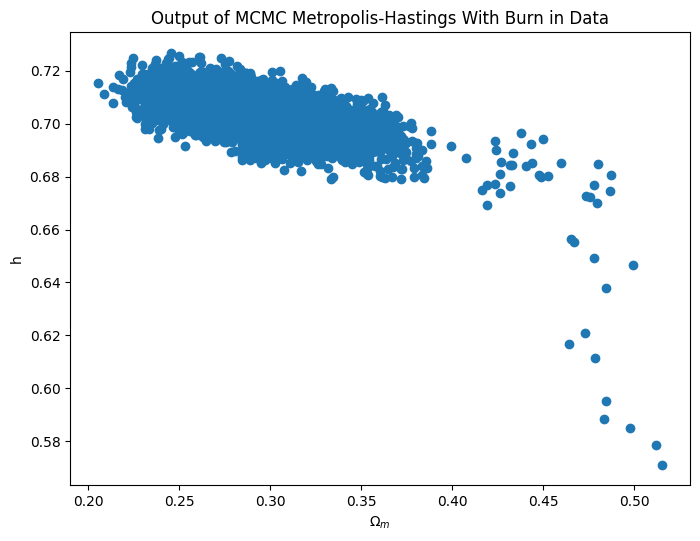

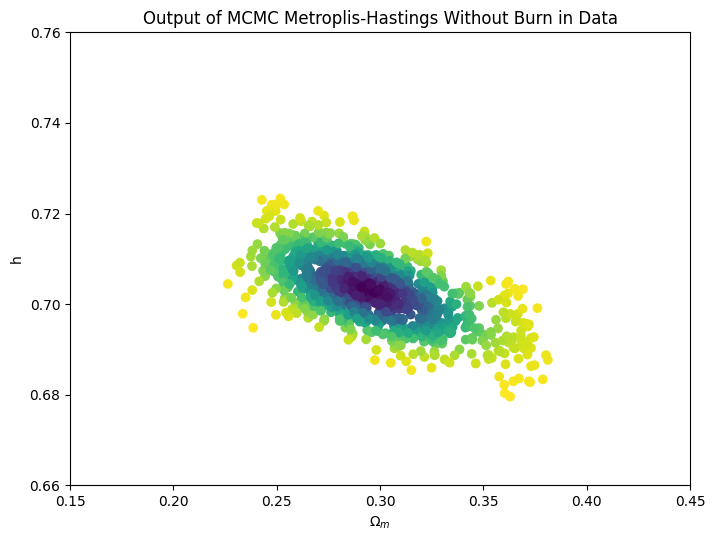

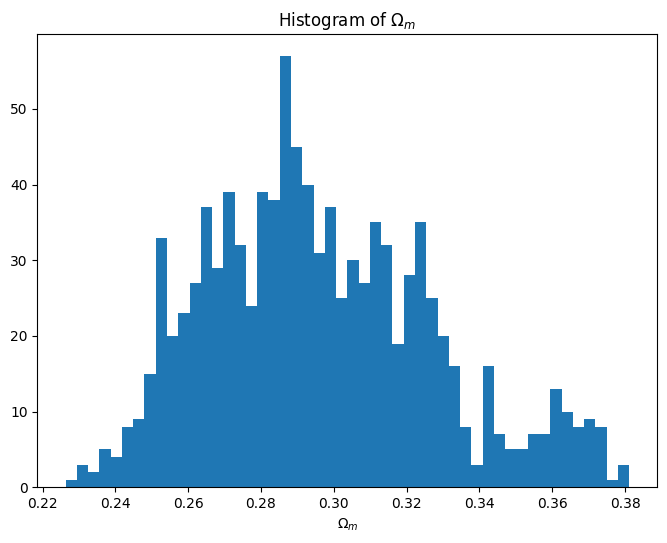

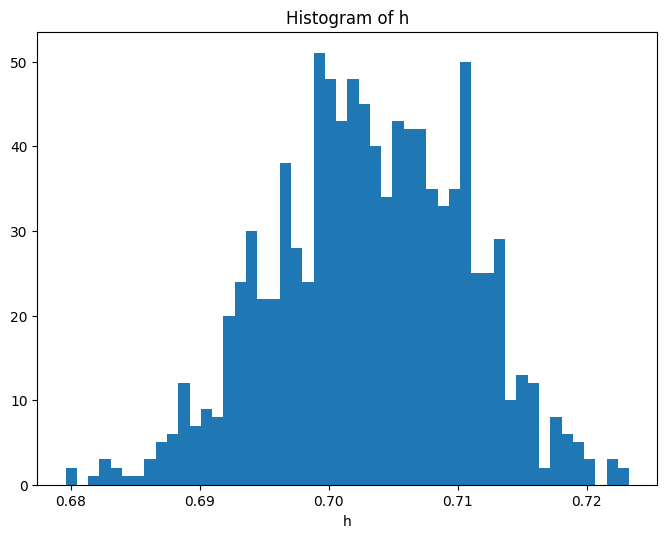

In [ ]:
#All the plots are here

'''
Plot of mu vs z for observed data and theoratical values of Omega_m and h
'''
plt.figure(figsize=(8,6), dpi=100)
plt.plot(z, mu,'o', label="Observed Data")

z_th = np.linspace(0.01, 1.4, 150)
mu_th1 = mu_theory(z_th, 0.3, 0.7)
mu_th2 = mu_theory(z_th, 0.2, 0.6)
mu_th3 = mu_theory(z_th, 0.4, 0.8)
plt.plot(z_th, mu_th1, label="$\Omega_m$ = 0.3, h = 0.7")
plt.plot(z_th, mu_th2, label="$\Omega_m$ = 0.2, h = 0.6")
plt.plot(z_th, mu_th3, label="$\Omega_m$ = 0.4, h = 0.8")
plt.ylabel('$\mu$')
plt.xlabel('z')
plt.title('Plot of $\mu$ vs z for observed data and theoratical values of $\Omega_m$ and h')
plt.legend()
plt.show()

'''
Output of MCMC Metropolis-Hastings With Burn in Data
'''

plt.figure(figsize=(8,6), dpi=100)
plt.scatter(omega_m_accept, h_accept)
plt.ylabel('h')
plt.xlabel('$\Omega_m$')
plt.title('Output of MCMC Metropolis-Hastings With Burn in Data')
# plt.xlim(0.15,0.45)
# plt.ylim(0.66,0.76)
plt.show()

'''
Output of MCMC Metropolis-Hastings Without Burn in Data
'''

plt.figure(figsize=(8,6), dpi=100)
plt.scatter(omega_m_accept[:burnin], h_accept[:burnin], c = -np.exp(prob)[:burnin])
plt.ylabel('h')
plt.xlabel('$\Omega_m$')
plt.title('Output of MCMC Metroplis-Hastings Without Burn in Data')
plt.xlim(0.15,0.45)
plt.ylim(0.66,0.76)
plt.show()

# Histogram of Omegam:
plt.figure(figsize=(8,6), dpi=100)
plt.hist(omega_m_accept[:burnin],bins=50)
plt.xlabel('$\Omega_m$')
plt.title('Histogram of $\Omega_m$')
plt.show()

# Histogram of h:
plt.figure(figsize=(8,6), dpi=100)
plt.hist(h_accept[:burnin],bins=50)
plt.xlabel('h')
plt.title('Histogram of h')
plt.show()